In [1]:
import warnings

# Ignore the first specific warning
warnings.filterwarnings(
    "ignore",
    message="plotting functions contained within `_documentation_utils` are intended for nemos's documentation.",
    category=UserWarning,
)

# Ignore the second specific warning
warnings.filterwarnings(
    "ignore",
    message="Ignoring cached namespace 'core'",
    category=UserWarning,
)

warnings.filterwarnings(
    "ignore",
    message=(
        "invalid value encountered in div "
    ),
    category=RuntimeWarning,
)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pynapple as nap

import nemos as nmo

nap.nap_config.suppress_conversion_warnings = True

# set random seed
np.random.seed(123)


In [3]:
n_neurons = 10
T = 50

times = np.linspace(0, T, 5000).reshape(-1, 1)
rate = np.exp(np.sin(times + np.linspace(0, np.pi*2, n_neurons).reshape(1, n_neurons)))


spike_t, spike_id = np.where(np.random.poisson(rate))
units = nap.Tsd(spike_t/T, spike_id).to_tsgroup()



In [4]:
glm = nmo.glm.PopulationGLM(
	solver_name="GradientDescent",
	solver_kwargs={"stepsize": 0.1, "acceleration": False}
	)
ws = 40
basis = nmo.basis.RaisedCosineLogConv(5, window_size=ws)


batch_size = 5  # second

def batcher():
	# Grab a random time within the time support. Here is the time support is one epoch only so it's easy.
	t = np.random.uniform(units.time_support[0, 0], units.time_support[0, 1]-batch_size)

	# Bin the spike train in a 1s batch
	ep = nap.IntervalSet(t, t+batch_size)
	counts = units.restrict(ep).count(0.005)  # count in 5 ms bins

	# Convolve
	X = basis.compute_features(counts)

	# Return X and counts
	return X, counts

params = glm.initialize_params(*batcher())
state = glm.initialize_state(*batcher(), params)

n_step = 500
logl = np.zeros(n_step)

for i in range(n_step):

	# Get a batch of data
	X, Y = batcher()

	# Do one step of gradient descent.
	params, state = glm.update(params, state, X, Y)

	# Score the model along the time axis
	logl[i] = glm.score(X, Y, score_type="log-likelihood")


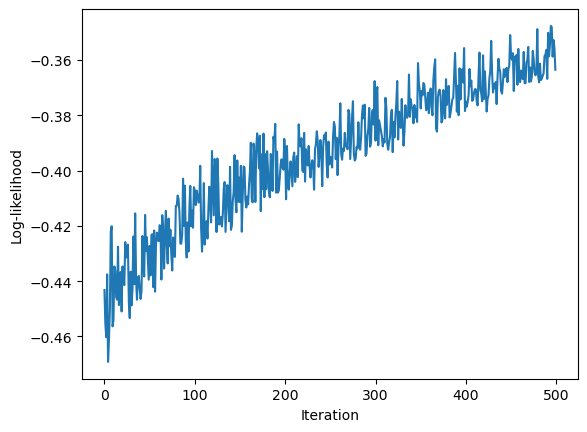

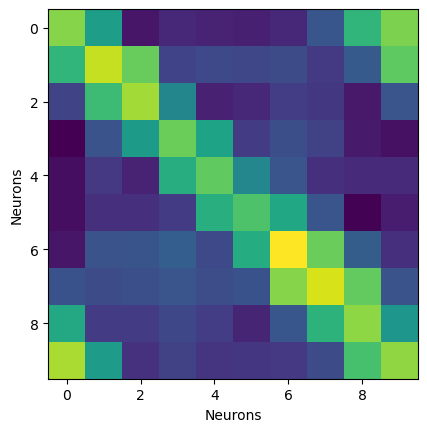

In [5]:
fig = plt.figure()
plt.plot(logl)
plt.xlabel("Iteration")
plt.ylabel("Log-likelihood")
plt.show()

# save image for thumbnail
from pathlib import Path
import os

root = os.environ.get("READTHEDOCS_OUTPUT")
if root:
   path = Path(root) / "html/_static/thumbnails/how_to_guide"
# if local store in ../_build/html/...
else:
   path = Path("../_build/html/_static/thumbnails/how_to_guide")

# make sure the folder exists if run from build
if root or Path("../assets/stylesheets").exists():
   path.mkdir(parents=True, exist_ok=True)

if path.exists():
  fig.savefig(path / "plot_04_batch_glm.svg")


W = glm.coef_.reshape(len(units), basis.n_basis_funcs, len(units))
Wm = np.mean(np.abs(W), 1)

# Let's plot it.

plt.figure()
plt.imshow(Wm)
plt.xlabel("Neurons")
plt.ylabel("Neurons")
plt.show()


2025-03-25 10:42:48.784331: E external/xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng35{k2=1,k5=3,k14=2} for conv %cudnn-conv = (f32[10,5,19957]{2,1,0}, u8[0]{0}) custom-call(%bitcast.70, %bitcast.76), window={size=40}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", metadata={op_name="jit(tensor_convolve)/jit(main)/vmap(vmap(jit(convolve)))/jit(_conv)/conv_general_dilated" source_file="/home/brendan/OneDrive/Masters/Code/COSYNE2025_Hackathon/nemos/src/nemos/convolve.py" source_line=54}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-03-25 10:42:49.003159: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.218965485s
Trying algorithm eng35{k2=1,k5=3,k14=2} for conv %cudnn-conv = (f32[10,5,19957]{2,1,0}, u8[0]{0}) custom-call(

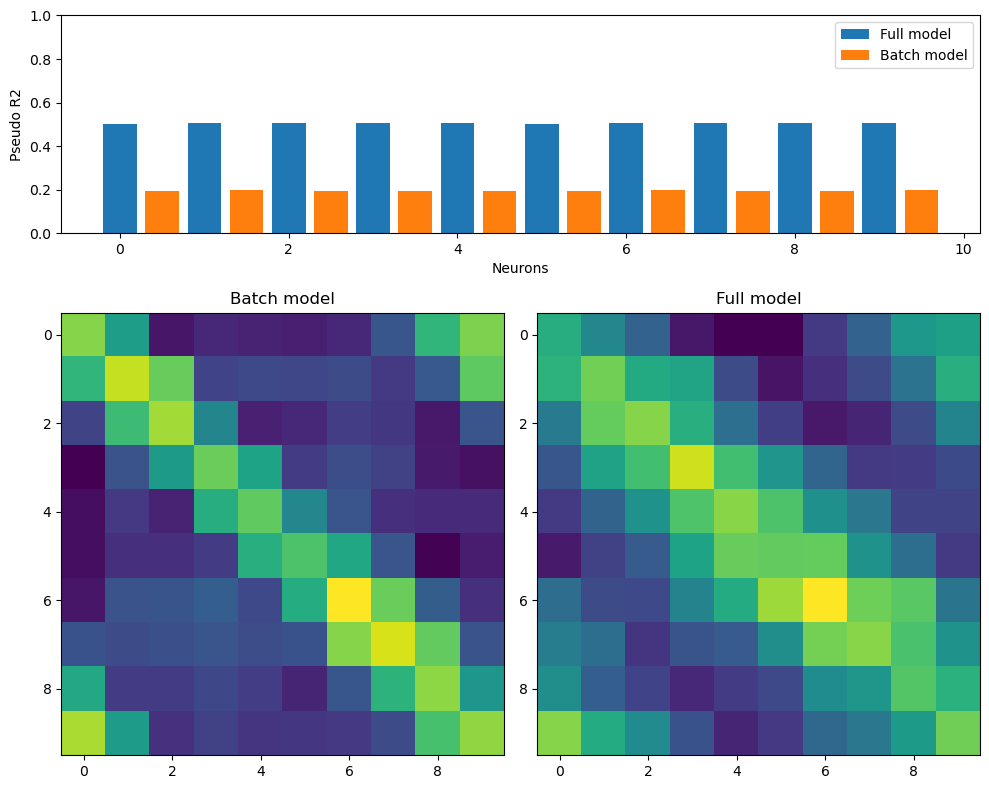

In [6]:
Y = units.count(0.005)
X = basis.compute_features(Y)
full_model = nmo.glm.PopulationGLM().fit(X, Y)

full_scores = full_model.score(
	X, Y, aggregate_sample_scores=lambda x:np.mean(x, axis=0), score_type="pseudo-r2-McFadden"
)
batch_scores = glm.score(
	X, Y, aggregate_sample_scores=lambda x:np.mean(x, axis=0), score_type="pseudo-r2-McFadden"
)

plt.figure(figsize=(10, 8))
gs = plt.GridSpec(3,2)
plt.subplot(gs[0,:])
plt.bar(np.arange(0, n_neurons), full_scores, 0.4, label="Full model")
plt.bar(np.arange(0, n_neurons)+0.5, batch_scores, 0.4, label="Batch model")
plt.ylabel("Pseudo R2")
plt.xlabel("Neurons")
plt.ylim(0, 1)
plt.legend()
plt.subplot(gs[1:,0])
plt.imshow(Wm)
plt.title("Batch model")
plt.subplot(gs[1:,1])
Wm2 = np.mean(
	np.abs(
		full_model.coef_.reshape(len(units), basis.n_basis_funcs, len(units))
		)
	, 1)
plt.imshow(Wm2)
plt.title("Full model")
plt.tight_layout()
plt.show()
